# Hand Gesture Classification Using HaGRID and MediaPipe

This project focuses on classifying hand gestures using the **HaGRID dataset** and **MediaPipe's hand tracking solution**.  
- The **HaGRID dataset** provides a large collection of labeled hand gestures.  
- **MediaPipe** extracts hand landmarks, which are then used for classification.  

The goal is to preprocess the dataset, extract hand landmarks from images, and train a machine learning model to recognize different hand gestures accurately.

## Importing Required Libraries  
Before proceeding, we need to import several essential libraries for data handling, visualization, computer vision, and machine learning.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mediapipe as mp
import cv2 # openCV to connect to our webcam
import uuid
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Load and Preview the Hand Landmarks Dataset  

- Read the dataset `hand_landmarks_data.csv` into a pandas DataFrame.  
- Display the first five rows of the dataset to inspect its structure and contents.

In [3]:
df = pd.read_csv('hand_landmarks_data.csv')
print(df.head())

           x1          y1            z1          x2          y2        z2  \
0  262.669968  257.304901 -3.649205e-07  257.417542  247.109055  0.004224   
1   83.351778  346.059113 -2.345265e-07   81.925037  328.562347 -0.011102   
2  187.756977  260.235492 -2.417307e-07  195.460579  241.506035 -0.000184   
3  114.976696  331.594238 -1.233261e-07  114.503494  320.549957 -0.002824   
4  188.795288  141.727867 -1.622995e-07  188.520905  127.947464 -0.002884   

           x3          y3        z3          x4  ...         x19         y19  \
0  246.882957  241.716827  0.005798  236.384537  ...  223.345093  255.490692   
1   90.080132  311.535248 -0.021096   95.641823  ...  132.451618  341.794434   
2  207.259529  223.674339 -0.009687  215.413628  ...  250.301010  268.602938   
3  116.636627  310.080994 -0.008911  117.685066  ...  145.195450  329.357544   
4  191.982880  111.010563 -0.008115  192.552521  ...  226.696396  132.263248   

        z19         x20         y20       z20         x2

In [4]:
# Checking for null values
df.isna().sum()

x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64

In [5]:
# Stats Information
df.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
count,25675.000000,25675.000000,2.567500e+04,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,...,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000,25675.000000
mean,201.958632,260.158527,1.272461e-07,202.517395,252.115322,-0.009465,202.862981,240.645966,-0.015946,203.025267,...,-0.024129,201.792374,227.455597,-0.033751,201.811275,227.802576,-0.032208,201.874802,227.807287,-0.028828
std,90.500333,76.533210,2.737932e-07,84.770933,75.384691,0.010376,80.412089,74.721921,0.013973,79.647588,...,0.015658,94.046497,77.231210,0.020453,93.664595,78.441253,0.020877,93.547017,79.963438,0.021136
min,-36.050926,45.722923,-2.029986e-06,7.184681,51.256840,-0.096630,25.114323,45.489950,-0.155846,23.446341,...,-0.201897,0.198635,20.146784,-0.286821,3.278137,32.158108,-0.286470,-4.537216,23.226204,-0.262047
25%,124.110329,205.815950,-5.243216e-08,130.535929,197.999625,-0.015199,136.711035,187.018583,-0.023020,138.905817,...,-0.030728,126.828913,172.720392,-0.042726,126.887403,172.345467,-0.041957,126.356627,172.083794,-0.039220
50%,199.667847,255.181793,1.497277e-07,199.979530,247.113892,-0.008737,200.092758,235.776978,-0.014231,200.482040,...,-0.020969,197.579865,221.781479,-0.029942,197.591736,222.381149,-0.028510,197.453270,222.485229,-0.025269
75%,266.428482,304.991663,2.989988e-07,261.147457,296.850769,-0.002783,255.876354,284.925993,-0.007134,254.622768,...,-0.013661,268.103920,273.190765,-0.019987,267.745743,274.196884,-0.017971,267.324657,275.805222,-0.014294
max,633.556020,781.674469,1.876254e-06,606.232386,751.869416,0.076365,598.541348,719.365010,0.094131,607.999801,...,0.031774,632.923029,779.419948,0.078105,638.134761,760.854103,0.104580,641.788521,760.554894,0.118668


## Encoding the Label Column  

- The `label` column contains categorical values (gesture names) that need to be converted into numerical format for machine learning models.  
- We use `LabelEncoder` from `sklearn.preprocessing` to transform the labels into numerical values.  
- The `.fit_transform()` method assigns a unique integer to each label.  
- Finally, `df['label'].unique()` displays the unique encoded values.

In [6]:
# Encode the label column
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

## Preparing Features and Target Variables  

- `X`: Contains the input features by dropping the `label` column and all `z`-coordinate columns (from `z1` to `z21`).  
  - The `z`-coordinates are removed because they represent depth, which may not be necessary for classification in a 2D space.  
- `y`: Stores the target variable, which is the encoded gesture label.  
- This step ensures that our model only trains on relevant hand landmark coordinates (x and y).

In [7]:
X = df.drop(['label'] + [f'z{i}' for i in range(1, 22)], axis=1)
y = df['label']

In [8]:
X.columns

Index(['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6',
       'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10', 'y10', 'x11', 'y11', 'x12',
       'y12', 'x13', 'y13', 'x14', 'y14', 'x15', 'y15', 'x16', 'y16', 'x17',
       'y17', 'x18', 'y18', 'x19', 'y19', 'x20', 'y20', 'x21', 'y21'],
      dtype='object')

## Splitting the Dataset into Training and Testing Sets  

- We use `train_test_split` from `sklearn.model_selection` to divide the dataset into training and testing sets.  
- `test_size = 0.20`: 20% of the data is reserved for testing, while 80% is used for training.  
- `random_state = 42`: Ensures reproducibility of results.  
- `shuffle = True`: Randomly shuffles the dataset before splitting.  
- `stratify = y`: Ensures that the class distribution remains balanced between training and testing sets.  

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42 \
                                                    , test_size = 0.20, shuffle = True, stratify = y)


## Standardizing the Feature Data  

- We use `StandardScaler` from `sklearn.preprocessing` to normalize the feature values.  
- Standardization ensures that all features have a mean of 0 and a standard deviation of 1, which helps many machine learning models perform better.  
- `fit_transform(X_train)`: Computes the mean and standard deviation from the training data and scales it accordingly.  
- `transform(X_test)`: Applies the same scaling parameters from the training data to the test set to maintain consistency.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Training a Random Forest Classifier  

- We use `RandomForestClassifier` from `sklearn.ensemble`, a robust ensemble learning method.  
- `n_estimators = 50`: The model consists of 50 decision trees to improve accuracy and reduce overfitting.  
- `random_state = 42`: Ensures reproducibility of results.  
- `.fit(X_train_scaled, y_train)`: Trains the model using the standardized training data.  
- `.predict(X_train_scaled)`: Predicts labels for the training set to evaluate how well the model has learned.  
- `.predict(X_test_scaled)`: Predicts labels for the test set to assess generalization performance.

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators= 50, random_state = 42)
classifier.fit(X_train_scaled, y_train)

y_pred_train = classifier.predict(X_train_scaled)
y_pred_test = classifier.predict(X_test_scaled)

train Accuracy: 100.00%
Test Accuracy: 83.88%


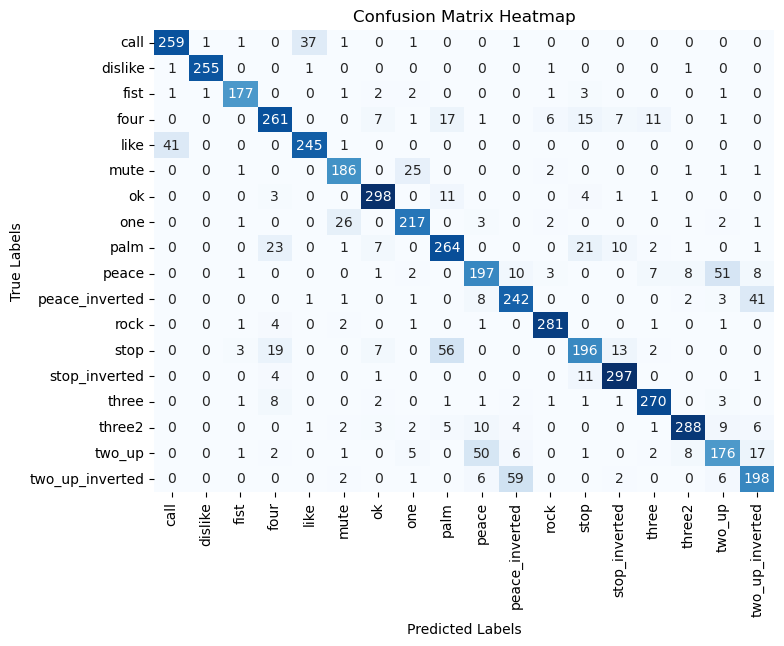

In [17]:
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'train Accuracy: {train_accuracy * 100:.2f}%')

test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Hyperparameter Tuning Using RandomizedSearchCV  

Since the initial Random Forest model exhibited **overfitting**, we perform **hyperparameter tuning** to improve generalization.  

### Steps:  
- **Define a parameter grid (`param_dist`)**:  
  - `n_estimators`: Number of trees in the forest (100, 120, 140).  
  - `max_depth`: Maximum depth of each tree (None, 5, 10, 15).  
  - `min_samples_split`: Minimum samples required to split a node (3 to 8).  
  - `min_samples_leaf`: Minimum samples required at a leaf node (1, 2, 4).  
  - `max_features`: Feature selection strategy (`'sqrt'`, `'log2'`) to reduce overfitting.  

- **Use `RandomizedSearchCV`**:  
  - `n_iter = 5`: Tests 5 different hyperparameter combinations.  
  - `cv = 3`: Uses **3-fold cross-validation** to evaluate each combination.  
  - `n_jobs = -1`: Utilizes all available CPU cores for faster processing.  
  - `random_state = 42`: Ensures reproducibility.  

- **Train the optimized model**:  
  - The best hyperparameters are extracted using `.best_params_`.  
  - The best model (`best_rf`) is trained using these parameters.  

- **Evaluate performance**:  
  - Compute and print accuracy for both training and test sets.  
  - This helps verify whether tuning has improved generalization.

In [86]:
# Because it's really overfitting we're going to try another set of H.P.
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 120 , 140],
    'max_depth' : [None, 5 ,10 ,15],
    'min_samples_split' : [3, 4, 5, 6, 7, 8],
    'min_samples_leaf' : [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# use regularization : 'max_features': ['sqrt', 'log2']

rf = RandomForestClassifier(random_state = 42)

random_search = RandomizedSearchCV(rf, param_distributions = param_dist,\
                                  n_iter = 5, cv=3, verbose = 2, n_jobs = -1 \
                                  , random_state = 42)
random_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", random_search.best_params_)

best_rf = random_search.best_estimator_

# Train Accuracy 
y_pred_train = best_rf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Optimized Train Accuracy: {train_accuracy * 100:.2f}%")

# Test accuracy
y_pred_test = best_rf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Optimized Test Accuracy: {test_accuracy * 100:.2f}%")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Optimized Train Accuracy: 99.61%
Optimized Test Accuracy: 83.15%


## Training the Optimized Random Forest Model on Selected Features  

- After hyperparameter tuning, we train the **best Random Forest model (`best_rf`)** using a refined feature set.  
- `X_train_selected` represents a subset of the original features, possibly obtained through feature selection techniques.  
- The model is trained on this optimized dataset to further improve performance and reduce overfitting.

In [ ]:
best_rf.fit(X_train_selected, y_train)

## Evaluating the Optimized Random Forest Model  

- **Predict on Training Data (`X_train_selected`)**:  
  - Use the trained `best_rf` model to predict labels for the training set.  
  - Compute **training accuracy** using `accuracy_score`.  

- **Predict on Test Data (`X_test_selected`)**:  
  - Evaluate the model’s generalization by predicting labels for the test set.  
  - Compute **test accuracy** using `accuracy_score`.  

- **Print Accuracy Scores**:  
  - Training accuracy helps assess how well the model fits the training data.  
  - Test accuracy indicates how well the model generalizes to unseen data.

In [85]:
y_pred_train = best_rf.predict(X_train_selected)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Optimized Train Accuracy: {train_accuracy * 100:.2f}%")

y_pred_test = best_rf.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Optimized Test Accuracy: {test_accuracy * 100:.2f}%")

Optimized Train Accuracy: 99.48%
Optimized Test Accuracy: 80.78%


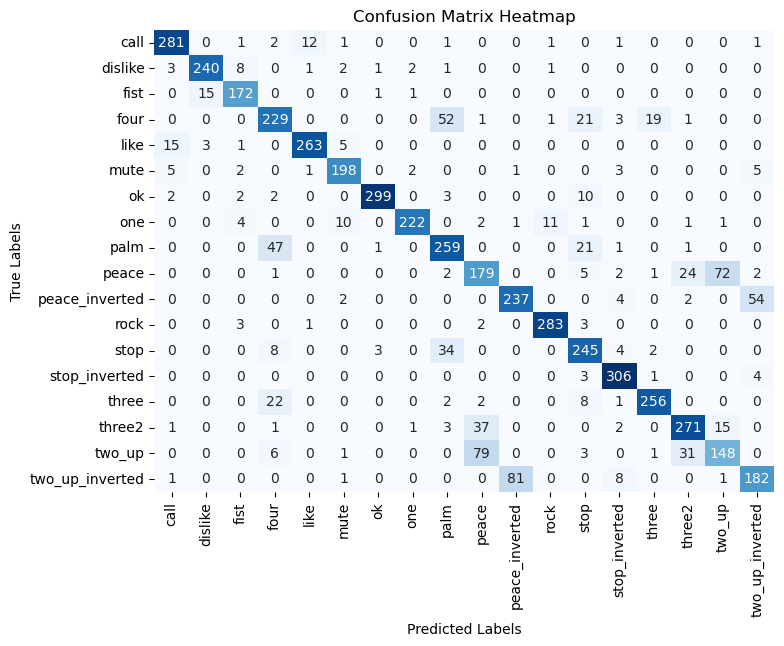

In [87]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Evaluating Model Performance Using Precision, Recall, and F1-Score  

- **Precision** (`precision_score`): Measures how many of the predicted positive instances were actually correct.  
- **Recall** (`recall_score`): Measures how many of the actual positive instances were correctly identified.  
- **F1-Score** (`f1_score`): The harmonic mean of precision and recall, providing a balanced evaluation of model performance.  

- We use `average='weighted'` to handle multi-class classification by computing a weighted mean of individual class scores.  
- The results help assess the model’s ability to balance false positives and false negatives.  

In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.832272858370189
Recall: 0.8315481986368062
F1-Score: 0.8312126167032072


## Since RandomForest Still Overfitting.. Let's Try Another Model! 😈

In [116]:
#import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(

    objective = "multi:softmax",
    num_class = len(label_encoder.classes_),
    eval_metric = 'mlogloss',
    random_state = 42
    
)

xgb_classifier.fit(X_train_scaled, y_train)

y_pred_train = xgb_classifier.predict(X_train_scaled)
y_pred_test = xgb_classifier.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)


print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy: 92.42%


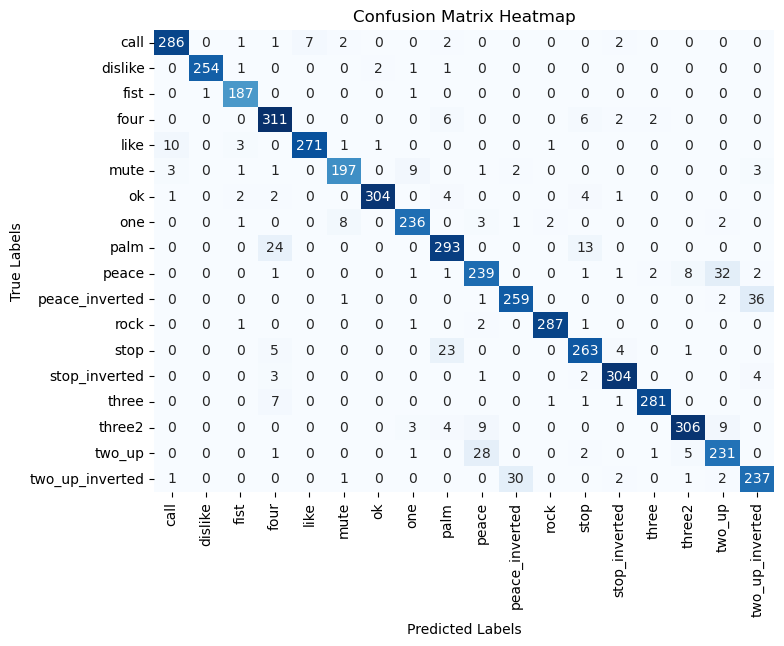

In [100]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'g', cmap ='Blues', cbar = False,
           xticklabels = class_names, yticklabels = class_names)


plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Hyperparameter Tuning for XGBoost Classifier  

Since the Random Forest model showed limitations, we experiment with **XGBoost**, a powerful gradient boosting algorithm, and tune its hyperparameters.  

### Steps:  

1. **Define the Hyperparameter Grid (`param_dist`)**:  
   - `n_estimators`: Number of boosting rounds (50, 100, 150, 200).  
   - `max_depth`: Maximum depth of trees (3, 5, 10, 15).  
   - `learning_rate`: Shrinks the contribution of each tree (0.01, 0.05, 0.08, 0.1).  
   - `subsample`: Fraction of data used for training (0.6, 0.8, 1.0).  
   - `colsample_bytree`: Fraction of features used per tree (0.6, 0.8, 1.0).  
   - `gamma`: Minimum loss reduction required for a split (0, 0.1, 0.2, 0.5).  

2. **Use `RandomizedSearchCV`**:  
   - `n_iter = 5`: Tests 5 random hyperparameter combinations.  
   - `cv = 3`: Uses **3-fold cross-validation** for validation.  
   - `n_jobs = -1`: Utilizes all CPU cores for faster computation.  
   - `random_state = 42`: Ensures reproducibility.  

3. **Train the Best Model**:  
   - The best hyperparameters are extracted using `.best_params_`.  
   - The best model (`best_xgb`) is trained using these optimal settings.  

4. **Evaluate Performance**:  
   - Compute **training and test accuracy** to assess model improvement. 

In [ ]:
# Let's Try Different Hypereparams for it

param_dist = {
    'n_estimators' : [50, 100, 150 , 200],
    'max_depth' : [3, 5, 10, 15],
    'learning_rate' : [0.01, 0.05, 0.08 , 0.1],
    'subsample' : [0.6, 0.8, 1.0],
    'colsample_bytree' : [0.6, 0.8, 1.0],
    'gamma' : [0, 0.1, 0.2, 0.5]
    
}

random_search = RandomizedSearchCV(xgb_classifier, param_distributions= param_dist,
                                  n_iter = 5, cv = 3, verbose = 2, n_jobs = -1,
                                  random_state =42)

# Get Best Hyperparameters
random_search.fit(X_train_scaled, y_train)

# Train Best Model
best_xgb = random_search.best_estimator_


best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

y_pred_train = best_xgb.predict(X_train_scaled)
y_pred_test = best_xgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Optimized Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Optimized Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
coef_matrix =  confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=8, 6)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [3]:
import sklearn
import xgboost

print("scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)

scikit-learn version: 1.6.1
XGBoost version: 2.1.1


## SVM 

## Training and Evaluating an SVM Model  

To further explore classification performance, we implement a **Support Vector Machine (SVM)** model with an **RBF (Radial Basis Function) kernel**.

### Steps:

1. **Define the SVM Model (`SVC`)**:
   - `kernel='rbf'`: Uses a **Radial Basis Function (RBF)** kernel to capture complex relationships.  
   - `C=1.0`: Regularization parameter to control margin width.  
   - `gamma='scale'`: Automatically sets the kernel coefficient.  
   - `random_state=42`: Ensures reproducibility.  

2. **Train the Model**:
   - Fit `svm_classifier` on the scaled training data.  

3. **Make Predictions**:
   - Predict labels for both training (`X_train_scaled`) and test (`X_test_scaled`) datasets.  

4. **Evaluate Model Performance**:
   - Compute **training accuracy** and **test accuracy** using `accuracy_score`.  
   - Compare results to identify signs of overfitting or underfitting.  

In [18]:
# Define SVM model
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', C=1.0,
                     gamma='scale', random_state=42)

# Train Model
svm_classifier.fit(X_train_scaled, y_train)

# Predict on Train & Test Set
y_pred_train = svm_classifier.predict(X_train_scaled)
y_pred_test = svm_classifier.predict(X_test_scaled)

# Evaluate Performance
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 82.12%
Test Accuracy: 80.90%


## Hyperparameter Tuning for SVM  

To improve the **SVM classifier's** performance, we perform **hyperparameter tuning** using `RandomizedSearchCV`.  

### Steps:  

1. **Define the Hyperparameter Grid (`param_dist`)**:  
   - `C`: Regularization parameter (0.1, 1, 10, 100).  
   - `gamma`: Controls the influence of each training sample ('scale', 'auto', 0.01, 0.1, 1).  
   - `kernel`: Tests different kernel functions ('rbf', 'linear', 'poly', 'sigmoid).  

2. **Apply `RandomizedSearchCV`**:  
   - `n_iter=20`: Tests 20 random hyperparameter combinations.  
   - `cv=3`: Uses **3-fold cross-validation**.  
   - `n_jobs=-1`: Utilizes all CPU cores for faster computation.  
   - `random_state=42`: Ensures reproducibility.  

3. **Train the Best Model (`best_svm`)**:  
   - The best hyperparameters are extracted using `.best_params_`.  
   - The optimized model (`best_svm`) is trained using the best settings.  

4. **Evaluate Performance**:  
   - Compute **training and test accuracy** using `accuracy_score`.  
   - Helps determine whether SVM outperforms other models (Random Forest, XGBoost).  

In [122]:
param_dist = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Try different kernels
}

random_search = RandomizedSearchCV(
    svm_classifier, param_distributions=param_dist,
    n_iter=20, cv=3, verbose=2, n_jobs=-1, random_state=42
)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_svm = random_search.best_estimator_

# Predict with Best Model
y_pred_train = best_svm.predict(X_train_scaled)
y_pred_test = best_svm.predict(X_test_scaled)

# Evaluate Again
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Optimized Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Optimized Test Accuracy: {test_accuracy * 100:.2f}%")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'kernel': 'poly', 'gamma': 1, 'C': 0.1}
Optimized Train Accuracy: 99.90%
Optimized Test Accuracy: 94.68%


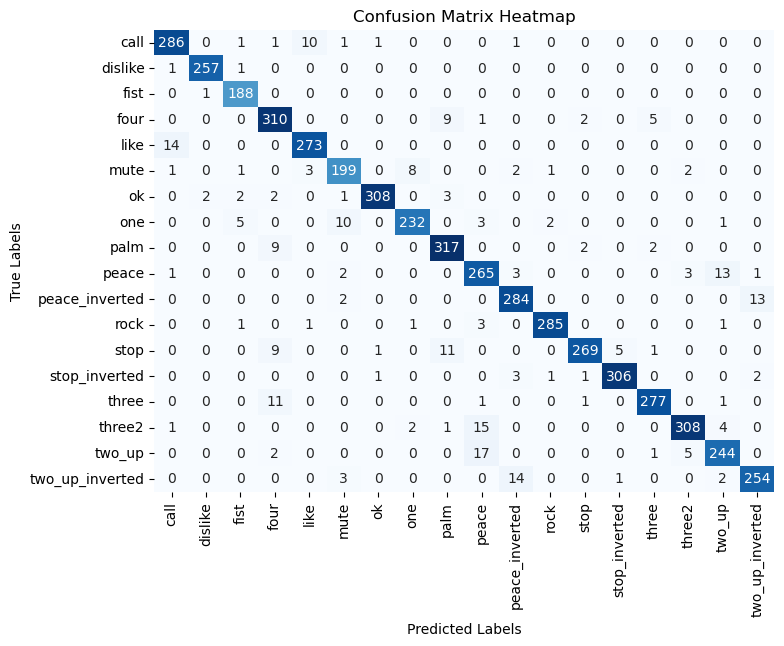

In [123]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'g', cmap ='Blues', cbar = False,
           xticklabels = class_names, yticklabels = class_names)


plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [134]:
from sklearn.metrics import classification_report

print("Train Metrics:")
print(classification_report(y_train, y_pred_train))

print("Test Metrics:")
print(classification_report(y_test, y_pred_test))

Train Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1205
           1       1.00      1.00      1.00      1036
           2       1.00      1.00      1.00       756
           3       1.00      1.00      1.00      1307
           4       1.00      1.00      1.00      1149
           5       1.00      1.00      1.00       870
           6       1.00      1.00      1.00      1274
           7       1.00      1.00      1.00      1010
           8       1.00      1.00      1.00      1319
           9       1.00      1.00      1.00      1153
          10       1.00      1.00      1.00      1198
          11       1.00      1.00      1.00      1166
          12       1.00      1.00      1.00      1186
          13       1.00      1.00      1.00      1253
          14       1.00      1.00      1.00      1165
          15       1.00      1.00      1.00      1322
          16       1.00      1.00      1.00      1074
          17

# Final Version
## SVM After the GridSearch


In [19]:
# Define SVM model
# {'kernel': 'poly', 'gamma': 1, 'C': 0.1}
from sklearn.svm import SVC

svm_classifier = SVC(kernel='poly', C=0.1,
                     gamma=1 , random_state=42)

# Train Model
svm_classifier.fit(X_train_scaled, y_train)

# Predict on Train & Test Set
y_pred_train = svm_classifier.predict(X_train_scaled)
y_pred_test = svm_classifier.predict(X_test_scaled)

# Evaluate Performance
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 97.48%
Test Accuracy: 94.72%


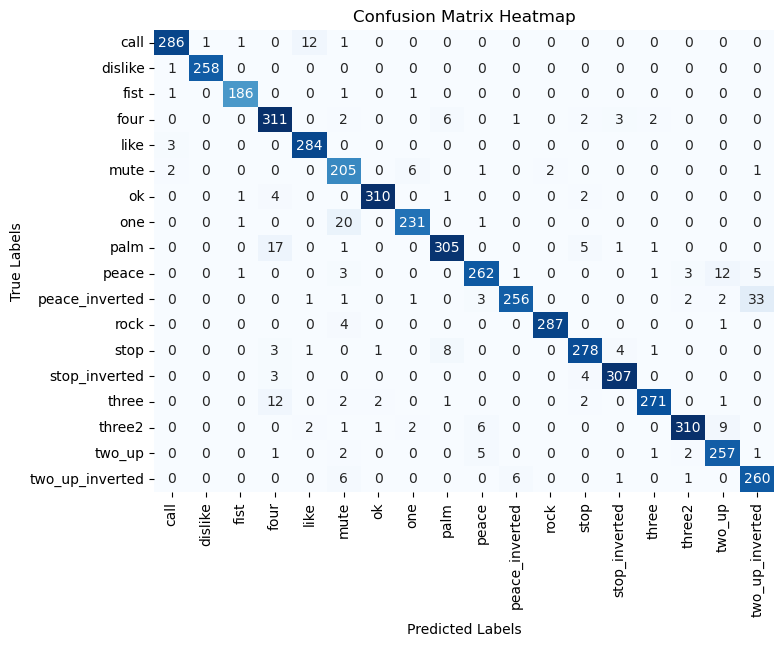

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'g', cmap ='Blues', cbar = False,
           xticklabels = class_names, yticklabels = class_names)


plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [20]:
from sklearn.metrics import classification_report

print("Train Metrics:")
print(classification_report(y_train, y_pred_train))

print("Test Metrics:")
print(classification_report(y_test, y_pred_test))

Train Metrics:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1205
           1       1.00      1.00      1.00      1036
           2       1.00      0.99      0.99       756
           3       0.94      0.99      0.96      1307
           4       0.98      1.00      0.99      1149
           5       0.88      0.99      0.93       870
           6       1.00      0.99      0.99      1274
           7       0.99      0.95      0.97      1010
           8       0.99      0.96      0.97      1319
           9       0.97      0.95      0.96      1153
          10       0.99      0.92      0.96      1198
          11       1.00      0.99      0.99      1166
          12       0.96      0.98      0.97      1186
          13       0.99      0.98      0.98      1253
          14       1.00      0.96      0.98      1165
          15       1.00      0.97      0.99      1322
          16       0.95      0.97      0.96      1074
          17

In [25]:
import joblib

# Save the trained svm model
joblib.dump(svm_classifier, "svm_model_woz.pkl")

# Save the LabelEncoder
joblib.dump(label_encoder, "label_encoder_woz.pkl")

joblib.dump(scaler, "scaler_woz.pkl")

print("Model and LabelEncoder saved successfully!")

Model and LabelEncoder saved successfully!
